# Load data and python libraries

In [1]:
# make plot s appear after the code cell
%matplotlib inline 

# data processing libraries
import pandas as pd

# display wider columns in pandas data frames where necessary
pd.set_option('max_colwidth',150)

# text processing libraries
import gensim
import re
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS

import en_core_web_md 

# Initialize spacy model, keeping only tagger component (for efficiency)
nlp = en_core_web_md.load(disable=['parser', 'ner'])

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# supporting libraries
import pickle
import numpy as np
import collections
from multiprocessing import Pool

In [2]:
# file location of the cleaned data frame
input_folder = './transition_files/'
output_folder = './transition_files/'

file_name = 'clean_data.pickle'

In [3]:
# load data
with open(input_folder + file_name, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    df_data = pickle.load(f)
    
# display first row of the data frame
df_data.tail(1).T

,272241
Hotel_ID,420
Hotel_originalname,HYATT PLACE
address,"1610 E Sonterra Blvd, San Antonio, TX 78258-7627"
price_range,"CN´712 - CN´1,047"
average_rating,4.5
number_of_reviews_hotel,633
hotel_star,3
Hotel_Name_tripadvisor,Hyatt Place San Antonio-North/Stone Oak
helpfulness_vote,0
mgtresponse_content,Thank you for taking the time out of your schedule to complete a review of our hotel on Trip Advisor regarding your recent stay at our hotel. Plea...


In [4]:
def print_review(df):
    """
    print single review as an example
    """
    row = df.iloc[0]
    review_rating = row['individual_ratings']
    title = row['review_title']
    text = row['review_content']
    
    print('Rating: ', review_rating)
    print('Title: ', title)
    print('Review: \n', text)
    print("="*100,'\n')

In [5]:
# review examples by rating
print_review(df_data[df_data['individual_ratings'] == 1])
print_review(df_data[df_data['individual_ratings'] == 2])
print_review(df_data[df_data['individual_ratings'] == 3])
print_review(df_data[df_data['individual_ratings'] == 4])
print_review(df_data[df_data['individual_ratings'] == 5])

Rating:  1
Title:  WARNING! Massive construction at the hotel right now.
Review: 
 WARNING! The entire lobby level and the level below are under construction...and yet the hotel is still charging full price for their rooms! I find this obnoxious. When we complained, they didn't do anything about it, which is even more obnoxious, especially considering the "restaurant" at the hotel is in the basement in what is normally a conference room (we felt like we were in makeshift poker room at a Holiday Inn i Reno). At these rates there are many better options in the downtown Austin area. I've stayed at this hotel many times and think the rooms are getting tired, too. We generally like the Four Seasons product, but they can do better.

Rating:  2
Title:  wouldn't honor group rate, room filthy, and very condescending.
Review: 
 My wife and I love to travel and we stay in four seasons all over the world. This one is not up to par. I was there for a sports tournament and provided my confirmation e

In [6]:
#combine review title and text
df_data['text'] = df_data['review_title'].fillna('').apply(str) + '.\n' + df_data['review_content']

In [7]:
#delete 3 star reviews
print ("Data size before the filter:", len(df_data))
df_data = df_data[df_data['individual_ratings'].isin([1,2,4,5])]
print ("Data size after the filter:", len(df_data))

Data size before the filter: 266805
Data size after the filter: 234404


# Spell check
The process is implemented using word2vec embeddings. It is an adaptation of Peter Norvig's spell checker. It uses word2vec ordering of words to approximate word probabilities.

I use pre-trained vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. 

This notebook requires word2vec model file GoogleNews-vectors-negative300.bin.gz that can be downloaded from Google's word2vec: https://code.google.com/archive/p/word2vec/ (I saved it in the "./data/" folder)

In [8]:
# import the model (takes less than 2 minutes to run)
%time model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

CPU times: user 1min 44s, sys: 1.92 s, total: 1min 46s
Wall time: 1min 46s


In [9]:
#example of words in the model:
words = model.index2word
words[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

In [10]:
#construct word rank dictionary
dict_tmp = dict(enumerate(words))
word_rank = dict(zip(dict_tmp.values(), dict_tmp.keys()))

#show start of the resulting dictionary
dict(list(word_rank.items())[:5])

{'</s>': 0, 'in': 1, 'for': 2, 'that': 3, 'is': 4}

Following steps are simple modification of Peter Norvig's code. Instead of computing the frequency of each word we use the word ranks stored in word_rank dictionary.

In [11]:
# Source: https://www.kaggle.com/cpmpml/spell-checker-using-word2vec/notebook
# with necessary  changes

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - word_rank.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    word = re.sub('[^a-zA-Z0-9]','0',word) 
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary word_rank."
    return set(w for w in words if w in word_rank)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [12]:
#spell check examples
print('"Cle3n" is transformed to "',correction('Cle3n'), '"')
print('"qalty" is transformed to "',correction('quality'), '"')

print('\nNOTE: missing spaces are not corrected and might generate errors of spell correction:')
print('"thetable" is transformed to "',correction('thetable'), '"')

print('\nNOTE: empty strings generate a single letter word surraunded by spaces:')
print('"" is transformed to "',correction(''), '"')
print('IT WILL BE USED TO MARKE END OF A SENTENCE')

"Cle3n" is transformed to " Clean "
"qalty" is transformed to " quality "

NOTE: missing spaces are not corrected and might generate errors of spell correction:
"thetable" is transformed to " timetable "

NOTE: empty strings generate a single letter word surraunded by spaces:
"" is transformed to " s "
IT WILL BE USED TO MARKE END OF A SENTENCE


Erroneous words that might appear in the reviews' texts after spell checking will be deleted during text preprocessing. Since most likely they will have low count of appearances in the reviews (it is unlikely that > 500 people will make the same mistake over and over).

Low count words will be deleted to reduce dimensionality of the dictionary of words that is used in the topic modeling.

In [13]:
# split review text on words
df_data['words'] = df_data['text'].str.replace(',',
                                               ' ').str.replace('[\t\n\r\f\v]',
                                                                '. ').str.replace(' +',
                                                                                  ' ').str.split('\W')

#check
print(df_data['text'].iloc[0])
print('\nTransformed to:\n')
print(df_data['words'].iloc[0])

Familia trip.
I like this hotel a lot. The location, the food, room service and all the personal is great!  IÕve stayed in a suite with a city view. And also in a standard room with the river view which is beautiful!Even though now they are remodeling the hotel, we had a pleasant stay. They made us feel at home. I canÕt wait to see it finished!

Transformed to:

['Familia', 'trip', '', '', 'I', 'like', 'this', 'hotel', 'a', 'lot', '', 'The', 'location', 'the', 'food', 'room', 'service', 'and', 'all', 'the', 'personal', 'is', 'great', '', 'IÕve', 'stayed', 'in', 'a', 'suite', 'with', 'a', 'city', 'view', '', 'And', 'also', 'in', 'a', 'standard', 'room', 'with', 'the', 'river', 'view', 'which', 'is', 'beautiful', 'Even', 'though', 'now', 'they', 'are', 'remodeling', 'the', 'hotel', 'we', 'had', 'a', 'pleasant', 'stay', '', 'They', 'made', 'us', 'feel', 'at', 'home', '', 'I', 'canÕt', 'wait', 'to', 'see', 'it', 'finished', '']


In [14]:
# since spell checking goes through each word in each review, full data check will take a lot of time
# we need to use parallel processing

def parallelize_dataframe(df, func, n_cores=4):
    """
    The function breaks the data frame (df) into n_cores parts, 
    and spawns n_cores processes which apply the function to all the pieces.
    
    Once the function (func) is applied to all the split data frames, 
    the split data frames are concatenated in the resulting data frame
    which is returned as an output.
    
    input:
         df - as pandas data frame
         func - function to be applied on the df
         n_cores - as integer, number of splits for data frame
    output
         df after application of the specified function
    """
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def spell_check(df):
    """ 
    spell check each word in the column "words" that represents list of tolkens from reviews
    and concatinate corrected words in a single text for each review 
    """
    df['spell_checked_text'] = df['words'].apply(lambda x: ' '.join([correction(word) if len(word)!=1 
                                                                     else  word for word in x])) 
    return df

In [15]:
# CHECK HOW MANY n_cores YOU CAN USE
# OPERATIONAL MEMORY CONSTRAIN: you need at least 20G of free RAM to run this step using all data (or do in chunks)
# run spell check in parallel to speed-up calculations (less than 15 minutes on my machine with parallelization)
%time df_data = parallelize_dataframe(df_data, spell_check, n_cores=15)

CPU times: user 16.2 s, sys: 8.55 s, total: 24.7 s
Wall time: 11min 46s


In [16]:
# replace " s " with "." to mark end of a sentence
df_data['spell_checked_text'] = df_data['spell_checked_text'].str.replace(' s ', '. ')
df_data['spell_checked_text'] = df_data['spell_checked_text'].str[:-2] + '.'

In [17]:
#check
print(df_data['text'].iloc[0])
print('\nTransformed to:\n')
print(df_data['spell_checked_text'].iloc[0])

Familia trip.
I like this hotel a lot. The location, the food, room service and all the personal is great!  IÕve stayed in a suite with a city view. And also in a standard room with the river view which is beautiful!Even though now they are remodeling the hotel, we had a pleasant stay. They made us feel at home. I canÕt wait to see it finished!

Transformed to:

Familia trip. s I like this hotel a lot. The location the food room service an all the personal is great. Ive stayed in a suite with a city view. And also in a standard room with the river view which is beautiful Even though now they are remodeling the hotel we had a pleasant stay. They made us feel at home. I cant wait two see it finished.


# Text tokenization and lemmatization

##### create spacy "nlp" object (takes time - 20 minutes on my machine)
it does several steps at once:
- tokenization
- POS tagging
- lemmatization instead of stemming (since we will be analyzing words in each topic it is important to preserve their language form)


You can find Spacy documentation for these steps here: https://spacy.io/api/annotation

In [18]:
# this step takes time (approximately 15 min on my machine)
%time df_data['doc'] = df_data['spell_checked_text'].apply(lambda x: nlp(x))

CPU times: user 14min 40s, sys: 6.02 s, total: 14min 46s
Wall time: 14min 47s


In [19]:
# delete stop words, select POSs that are letters and correspond to words with at least 3 characters 
df_data['list_of_POSs'] = df_data['doc'].apply(lambda x: [word.pos_
                                    for word in x if (word.is_stop==False) & \
                                                          (len(word.text)>2) & \
                                                          (word.is_alpha) 
                                                         ])

POS is more about the context of the features than frequencies of features

Total number of POSs:  17
POS = ADP means conjunction, subordinating or preposition
POS = INTJ means interjection

Other interpretations can be found here: https://spacy.io/api/annotation#pos-tagging
In "Universal Part-of-speech Tags" or "English" sections


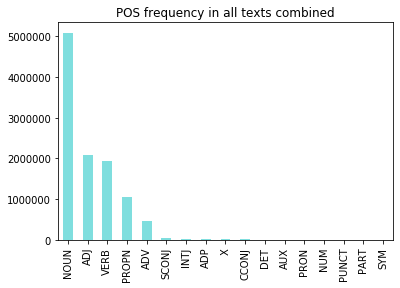

In [20]:
# get all POSs in each review in a list
tmp_list = df_data['list_of_POSs'].tolist()
list_of_POSs = [POS for sublist in tmp_list for POS in sublist]

#count POSs' total frequencies in the corpus
POS_freq_counter = collections.Counter(list_of_POSs)
s_POS_freq = pd.Series(POS_freq_counter)

#sort POSs document frequencies in the corpus 
s_tmp = s_POS_freq.sort_values(ascending=False)

print('Total number of POSs: ', len(set(s_POS_freq)))
print('POS = ADP means conjunction, subordinating or preposition')
print('POS = INTJ means interjection')
print('\nOther interpretations can be found here: https://spacy.io/api/annotation#pos-tagging')
print('In "Universal Part-of-speech Tags" or "English" sections')
df_tmp = pd.DataFrame(s_tmp, columns=['Frequency'])

#plot df_tmp
df_tmp.plot.bar(alpha=0.5, color='c', legend=False, title='POS frequency in all texts combined')

##### I recommend selecting only lemmas that have most meaning: nouns, verbs, adjectives and adverbs

In [21]:
#selecting POSs
selected_POSs = ['NOUN', 'VERB', 'ADJ', 'ADV']

print('selecting POSs:')
selected_POSs 

selecting POSs:


['NOUN', 'VERB', 'ADJ', 'ADV']

In [22]:
# lemmatize words with selected POSs, 
# select lemmas that are not stop-words and have at least 3 characters
df_data['list_of_lemmas'] = df_data['doc'].apply(lambda x: [word.lemma_
                                                                for word in x if (word.is_stop==False) & \
                                                                                 (len(word.text)>2) & \
                                                                                 (word.is_alpha) & \
                                                                                 (word.pos_ in selected_POSs)])

In [23]:
# example of a review
ind = 0

print(df_data['text'].iloc[ind])
print('\n#Selected lemmas:\n')
print(df_data['list_of_lemmas'].iloc[ind])

Familia trip.
I like this hotel a lot. The location, the food, room service and all the personal is great!  IÕve stayed in a suite with a city view. And also in a standard room with the river view which is beautiful!Even though now they are remodeling the hotel, we had a pleasant stay. They made us feel at home. I canÕt wait to see it finished!

#Selected lemmas:

['trip', 'like', 'hotel', 'lot', 'location', 'food', 'room', 'service', 'personal', 'great', 'stay', 'suite', 'city', 'view', 'standard', 'room', 'river', 'view', 'beautiful', 'remodel', 'hotel', 'pleasant', 'stay', 'feel', 'home', 'wait', 'finish']


##### Checking dictionary dimension  (number of unique lemmas) that will be in the model
bigger count longer model processing time without accuracy guarantee

In [24]:
# get all unique lemmas from each review in a list
tmp_list = df_data['list_of_lemmas'].apply(set).apply(list).tolist()
list_of_lemmas = [lemma for sublist in tmp_list for lemma in sublist]

# count lemmas' document frequencies in the corpus
lemma_freq_counter = collections.Counter(list_of_lemmas)
s_lemma_freq = pd.Series(lemma_freq_counter)

print('Total number of unique lemmas: ', len(s_lemma_freq))
print ("\nDistribution of lemmas' document counts: ")
print(s_lemma_freq.describe(percentiles=[0.55, 0.65, 0.75, 0.85, 0.95, 0.97, 0.99]))

Total number of unique lemmas:  32069

Distribution of lemmas' document counts: 
count     32069.000000
mean        250.199538
std        2598.039119
min           1.000000
50%           3.000000
55%           4.000000
65%           7.000000
75%          17.000000
85%          55.000000
95%         510.000000
97%        1188.960000
99%        4905.000000
max      155892.000000
dtype: float64


In [25]:
# look through to 20 most/least frequent lemmas 
s_tmp = s_lemma_freq.sort_values(ascending=False)
df_tmp = pd.DataFrame({'Most freq words': list(s_tmp.index[:20]),
                       'M_freq': list(s_tmp.iloc[:20]),
                       'Least freq words': list(s_tmp.index[-20:]),
                       'L_freq': list(s_tmp.iloc[-20:])})
df_tmp

,Most freq words,M_freq,Least freq words,L_freq
0,hotel,155892,surpriseused,1
1,room,155423,technophobe,1
2,stay,151267,billiards,1
3,staff,115312,taekwondo,1
4,great,111500,painstaff,1
5,good,85267,cubit,1
6,clean,83720,providedstaye,1
7,nice,77861,precipitate,1
8,breakfast,71441,delineation,1
9,location,66725,dustry,1


To reduce dimentionality of dictionary for topic modeling 
lemmas that have frequency count lower than 50th percentile and higer 99.9 percentile were deleted

In [26]:
# select upper and lower boundary for lemmas' count 
up_pct = s_lemma_freq.quantile(0.99)
low_pct = s_lemma_freq.quantile(0.50)

print('Lemma count upper bound:', up_pct)
print('Lemma count lower bound:', low_pct)

Lemma count upper bound: 4905.0
Lemma count lower bound: 3.0


In [29]:
# select lemmas 
selected_lemmas = set(s_lemma_freq[(s_lemma_freq >= low_pct)&(s_lemma_freq <= up_pct)].index)
print('List of lemmas for topic modeling dictionary is reduced from', len(s_lemma_freq), 'to', len(selected_lemmas))

print("\nExample of selected lemmas:")
list(selected_lemmas)[:5]

List of lemmas for topic modeling dictionary is reduced from 32069 to 16466

Example of selected lemmas:


['merienda', 'abate', 'fleshing', 'overcooked', 'modification']

In [30]:
# select lemmas in each document if they belong to chosen list of lemmas
df_data['selected_list_of_lemmas'] = df_data['list_of_lemmas'].apply(lambda x: 
                                                                     [l for l in x if l in selected_lemmas])

In [31]:
# select only necesary columns to transfer to the next step
columns = ['Hotel_ID', 'average_rating', 'hotel_star',
          'individual_ratings', 'review_content','review_time', 'review_title',
          'quarter', 'day_of_week', 'year', 'month', 'year-month', 'year-quarter',
          'py_review_date', 'selected_list_of_lemmas'
         ]

# Summary of text preprocessing 

Steps performed:
- spell correction
- tokenization
- POS tagging
- lemmatization
- deletion of commonly known STOP-WORDS
- selected only reviews with 1,2 and 4,5 ratings
- selected only most informative lemmas (nouns, verbs, adjective and adverbs)


Notably, words "nice", "clean", "good" and "great" are among in-sample STOP-WORDS (lemmas that appear to often or too infrequently).

It might be the case that people don't like to make completely negative review and still want to say something nice even if the overall rating is bad.

We might need to delete in-sample STOP-WORDS if they interfere with topic modeling.


### Transfer data frame between Jupiter notebooks
Next step "Topic modeling" is coded in separate Jupiter notebook. So that
- it is easier to locate program for a particular task
- Jupiter notebook is not very long and easier to read

Use pickle.load() to save pandas data frame with processed text data preserving object structure to be used in other programs

In [32]:
with open(output_folder + 'for_topic_modeling.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(df_data[columns], f, pickle.HIGHEST_PROTOCOL)